In [4]:
import torch
import torch.nn.functional as F


In [17]:
# Example data (replace these with your actual tensors)
epochs_set1 = torch.randn((100, 64, 200))  # Replace with your data dimensions
epochs_set2 = torch.randn((100, 64, 200))  # Replace with your data dimensions
epochs_set2 = epochs_set1 + 0.01*epochs_set2  # Replace with your data dimensions

In [18]:
# Apply softmax along the channel dimension to make sure the tensors represent probabilities
prob_set1 = F.softmax(epochs_set1, dim=1)
prob_set2 = F.softmax(epochs_set2, dim=1)

# Compute KL divergence element-wise for each pair of epochs
kl_divergence = F.kl_div(torch.log(prob_set1), prob_set2, reduction='none').sum(dim=(1, 2))


In [19]:
kl_divergence.mean()

tensor(0.0096)

In [61]:
import mne
import numpy as np

# Load your MNE data file (replace 'your_datafile.fif' with your actual data file)
raw = mne.io.read_raw_fif('/home/user/mne_data/MNE-multimodal-data/multimodal_raw.fif', preload=True)
info = raw.info
# Get the channel indices corresponding to gradiometers
grad_indices = mne.pick_types(info, meg='grad')

# Get the coordinates of the gradiometer sensors
sensor_positions = [info['chs'][grad_ind] for grad_ind in grad_indices]

# Find the center of the sensor positions (median along x, y, z coordinates)
center_x = np.median([pos['loc'][0] for pos in sensor_positions])
center_y = np.median([pos['loc'][1] for pos in sensor_positions])
center_z = np.median([pos['loc'][2] for pos in sensor_positions])

# Select gradiometer channels corresponding to the frontal half of the head
frontal_indices = [i for i, pos in enumerate(sensor_positions) if pos['loc'][1] >= center_y]

# Extract the frontal gradiometer channels
frontal_meg_data = raw[frontal_indices][0]

# Create a new Raw object with only the frontal channels
frontal_raw = raw.copy().pick(picks=frontal_indices)

# Save the new Raw object to a file if needed
# frontal_raw.save('frontal_half_meg.fif', overwrite=True)


Opening raw data file /home/user/mne_data/MNE-multimodal-data/multimodal_raw.fif...
    Read a total of 7 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
    Range : 183600 ... 576599 =    305.687 ...   960.014 secs
Ready.
Reading 0 ... 392999  =      0.000 ...   654.328 secs...


In [41]:
len(frontal_raw.info['ch_names'])

102

In [55]:
import os
from mne.datasets import multimodal

fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs = epochs.pick_types(meg='grad')

Opening raw data file /home/user/mne_data/MNE-multimodal-data/multimodal_raw.fif...
    Read a total of 7 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
    Range : 183600 ... 576599 =    305.687 ...   960.014 secs
Ready.
Not setting metadata
118 matching events found
Setting baseline interval to [-0.09989760657919393, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 7)
7 projection items activated
Not setting metadata
129 matching events found
Setting baseline interval to [-0.09989760657919393, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 7)
7 projectio

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


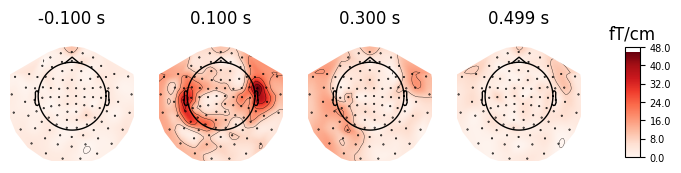

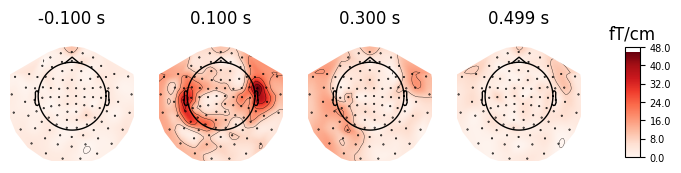

In [52]:
epochs.average().plot_topomap()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


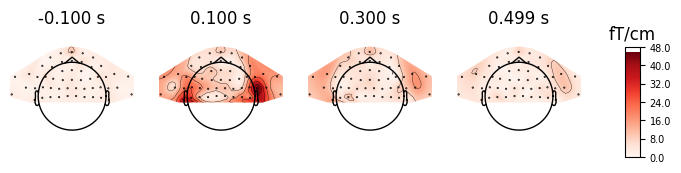

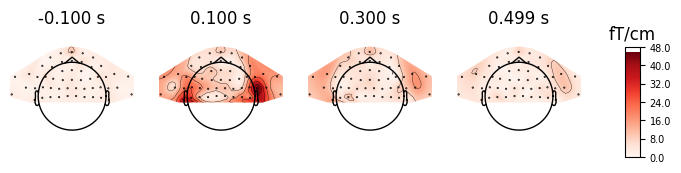

In [62]:
epochs.copy().pick(picks=frontal_indices).average().plot_topomap()

In [65]:
def get_frontal_indices(info: mne.Info) -> list[int]:
    """
    Select gradiometer channels corresponding to the frontal half of the head.

    Args:
        info (mne.Info): The MNE Info object containing sensor information.

    Returns:
        list: A list of indices corresponding to the selected gradiometer channels.
    """
    # Get the channel indices corresponding to gradiometers
    grad_indices = mne.pick_types(info, meg=True, eeg=True)

    # Get the coordinates of the gradiometer sensors
    sensor_positions = [info['chs'][grad_ind] for grad_ind in grad_indices]

    # Find the center of the sensor positions (median along y coordinates)
    center_y = np.median([pos['loc'][1] for pos in sensor_positions])

    # Select gradiometer channels corresponding to the frontal half of the head
    frontal_indices = [i for i, pos in enumerate(sensor_positions) if pos['loc'][1] >= center_y]

    return frontal_indices

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


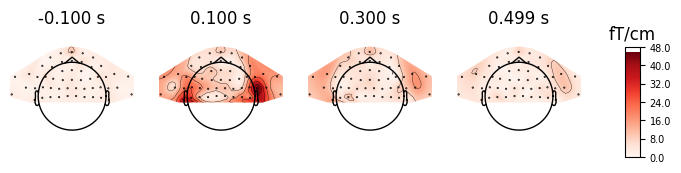

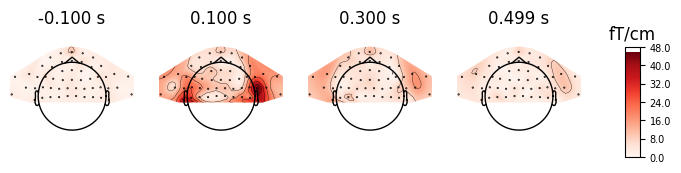

In [67]:
epochs.copy().pick(picks=get_frontal_indices(epochs.info)).average().plot_topomap()

In [68]:
epochs.get_data().shape

(940, 204, 361)

In [69]:
epochs.pick(picks=get_frontal_indices(epochs.info)).get_data().shape

(940, 104, 361)